---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the Jupyter Notebook FAQ course resource._

---

# Assignment 4 - Predicting and understanding viewer engagement with educational videos 

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. This assignment gives you an example of how machine learning can be used to address part of that challenge.

## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

We chose this prediction problem for several reasons:

* It combines a variety of features derived from a rich set of resources connected to the original data;
* The manageable dataset size means the dataset and supervised models for it can be easily explored on a wide variety of computing platforms;
* Predicting popularity or engagement for a media item, especially combined with understanding which features contribute to its success with viewers, is a fun problem but also a practical representative application of machine learning in a number of business and educational sectors.


## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

Note: Any extra variables that may be included in the training set are simply for your interest if you want an additional source of data for visualization, or to enable unsupervised and semi-supervised approaches. However, they are not included in the test set and thus cannot be used for prediction. **Only the data already included in your Coursera directory can be used for training the model for this assignment.**

For this final assignment, you will bring together what you've learned across all four weeks of this course, by exploring different prediction models for this new dataset. In addition, we encourage you to apply what you've learned about model selection to do hyperparameter tuning using training/validation splits of the training data, to optimize the model and further increase its performance. In addition to a basic evaluation of model accuracy, we've also provided a utility function to visualize which features are most and least contributing to the overall model performance.

**File descriptions** 
    assets/train.csv - the training set (Use only this data for training your model!)
    assets/test.csv - the test set
<br>

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

Your predictions will be given as the probability that the corresponding video will be engaging to learners.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model with an AUC (area under ROC curve) of at least 0.8 passes this assignment, and over 0.85 will receive full points.
___

For this assignment, create a function that trains a model to predict significant learner engagement with a video using `asset/train.csv`. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from `readonly/test.csv` will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the `id` field.

Example:

    id
       9240    0.401958
       9241    0.105928
       9242    0.018572
                 ...
       9243    0.208567
       9244    0.818759
       9245    0.018528
             ...
       Name: engagement, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out and check your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. 

* Try to avoid global variables. If you have other functions besides engagement_model, you should move those functions inside the scope of engagement_model.

* Be sure to first check the pinned threads in Week 4's discussion forum if you run into a problem you can't figure out.

### Extensions

* If this prediction task motivates you to explore further, you can find more details here on the original VLE dataset and others related to video engagement: https://github.com/sahanbull/VLE-Dataset



In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   # Do not change this value: required to be compatible with solutions generated by the autograder.

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## Cross Validating different models to see which one has better AOC:

In [3]:
# Load the training data
train_data = pd.read_csv('assets/train.csv')

# Separate the features and target variable
X_train = train_data.drop(columns=['engagement'])
y_train = train_data['engagement']

# Define the models to test
models = [
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Logistic Regression', LogisticRegression(random_state=0)),
    ('Decision Tree', DecisionTreeClassifier(random_state=0)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=0)),
    ('Support Vector Machine', SVC(random_state=0)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Neural Network', MLPClassifier(random_state=0)),
    ('Naive Bayes', GaussianNB())
]

# Perform cross-validation for each model and calculate the mean AUC score
for model_name, model in models:
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'{model_name}: Mean AUC Score = {mean_auc:.4f}')

Random Forest: Mean AUC Score = 0.8587

Logistic Regression: Mean AUC Score = 0.8225

Decision Tree: Mean AUC Score = 0.6402

Gradient Boosting: Mean AUC Score = 0.8611

Support Vector Machine: Mean AUC Score = 0.5617

K-Nearest Neighbors: Mean AUC Score = 0.5254

Neural Network: Mean AUC Score = 0.4463

Naive Bayes: Mean AUC Score = 0.8259


## Calculate the importance of each variable in the Random Forest model

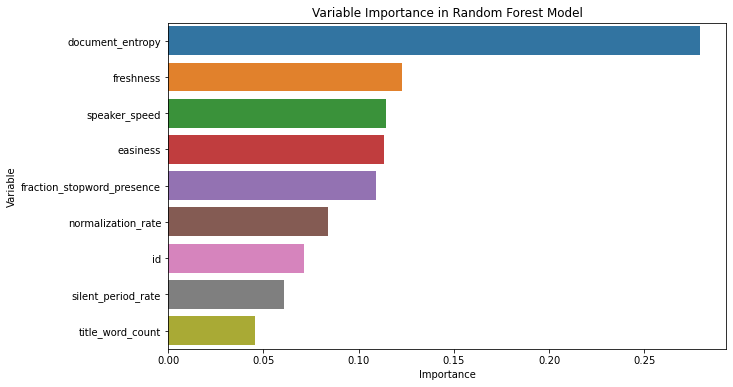

In [4]:
# Train the Random Forest classifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# Calculate the importance of each variable in the Random Forest model
importance = model.feature_importances_

# Create a DataFrame with the variable names and their importance scores
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the variable importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=importance_df)
plt.title('Variable Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.show()

## Removing column 'id' from the models

In [5]:
# Load the training data
train_data = pd.read_csv('assets/train.csv', index_col='id')

# Separate the features and target variable
X_train = train_data.drop(columns=['engagement'])
y_train = train_data['engagement']

# Perform cross-validation for each model and calculate the mean AUC score
for model_name, model in models:
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'{model_name}: Mean AUC Score = {mean_auc:.4f}')

Random Forest: Mean AUC Score = 0.8864

Logistic Regression: Mean AUC Score = 0.8253

Decision Tree: Mean AUC Score = 0.7044

Gradient Boosting: Mean AUC Score = 0.8834

Support Vector Machine: Mean AUC Score = 0.3792

K-Nearest Neighbors: Mean AUC Score = 0.7423

Neural Network: Mean AUC Score = 0.4373

Naive Bayes: Mean AUC Score = 0.8232


## Calculate the importance of each variable in the Random Forest model without 'id'

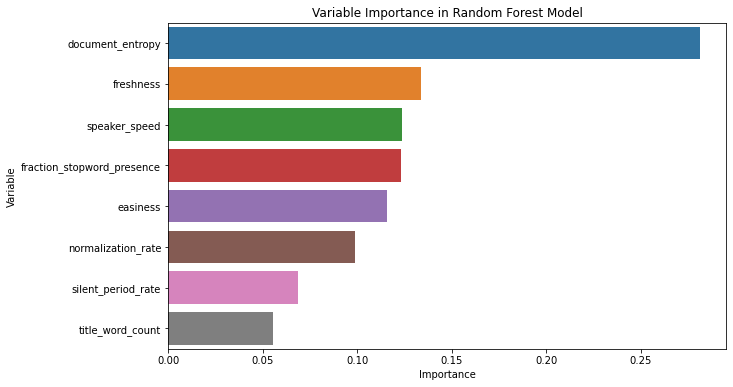

In [6]:
# Train the Random Forest classifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# Calculate the importance of each variable in the Random Forest model
importance = model.feature_importances_

# Create a DataFrame with the variable names and their importance scores
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the variable importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=importance_df)
plt.title('Variable Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.show()

## Testing different kernels in Support Vector Machine model

In [7]:
# Define the different kernels to test
kernels = ['poly', 'rbf', 'sigmoid']

# Perform cross-validation for each kernel and calculate the mean AUC score
for kernel in kernels:
    model = SVC(kernel=kernel, random_state=0)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'Support Vector Machine with {kernel} kernel: Mean AUC Score = {mean_auc:.4f}')

Support Vector Machine with poly kernel: Mean AUC Score = 0.6563

Support Vector Machine with rbf kernel: Mean AUC Score = 0.3792

Support Vector Machine with sigmoid kernel: Mean AUC Score = 0.3790


## Testing parameter degree from kernel = poly

In [8]:
degrees = [2, 3, 4, 5, 6]

# Perform cross-validation for each degree and calculate the mean AUC score
for degree in degrees:
    model = SVC(kernel='poly',degree = degree, random_state=0)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'Support Vector Machine(poly) with degree {degree}: Mean AUC Score = {mean_auc:.4f}')

Support Vector Machine(poly) with degree 2: Mean AUC Score = 0.6226

Support Vector Machine(poly) with degree 3: Mean AUC Score = 0.6563

Support Vector Machine(poly) with degree 4: Mean AUC Score = 0.7100

Support Vector Machine(poly) with degree 5: Mean AUC Score = 0.6451

Support Vector Machine(poly) with degree 6: Mean AUC Score = 0.7414


## Testing parameter C from kernel = poly

In [9]:
C_values = [1, 3, 5, 7, 10]

# Perform cross-validation for each C and calculate the mean AUC score
for C in C_values:
    model = SVC(kernel='poly',degree = 4,C=C, random_state=0)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'Support Vector Machine(poly) with C {C}: Mean AUC Score = {mean_auc:.4f}')

Support Vector Machine(poly) with C 1: Mean AUC Score = 0.7100

Support Vector Machine(poly) with C 3: Mean AUC Score = 0.7335

Support Vector Machine(poly) with C 5: Mean AUC Score = 0.7527

Support Vector Machine(poly) with C 7: Mean AUC Score = 0.7728

Support Vector Machine(poly) with C 10: Mean AUC Score = 0.7917


## Testing parameters gamma and C from kernel = rbf

In [10]:
gammas = [0.001,0.01,0.1,1]

# Perform cross-validation for each gamma and calculate the mean AUC score
for gamma in gammas:
    model = SVC(kernel='rbf', gamma=gamma, random_state=0)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'Support Vector Machine (RBF) with gamma {gamma}: Mean AUC Score = {mean_auc:.4f}')

C_values = [1, 3, 5, 7, 10]

# Perform cross-validation for each C and calculate the mean AUC score
for C in C_values:
    model = SVC(kernel='rbf', gamma='scale', C=C, random_state=0)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'Support Vector Machine (RBF) with C {C}: Mean AUC Score = {mean_auc:.4f}')

Support Vector Machine (RBF) with gamma 0.001: Mean AUC Score = 0.7719

Support Vector Machine (RBF) with gamma 0.01: Mean AUC Score = 0.7378

Support Vector Machine (RBF) with gamma 0.1: Mean AUC Score = 0.6980

Support Vector Machine (RBF) with gamma 1: Mean AUC Score = 0.6679

Support Vector Machine (RBF) with C 1: Mean AUC Score = 0.3792

Support Vector Machine (RBF) with C 3: Mean AUC Score = 0.5046

Support Vector Machine (RBF) with C 5: Mean AUC Score = 0.5055

Support Vector Machine (RBF) with C 7: Mean AUC Score = 0.5072

Support Vector Machine (RBF) with C 10: Mean AUC Score = 0.5205


## Testing parameters from RandomForest model

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Best AUC Score: 0.8921


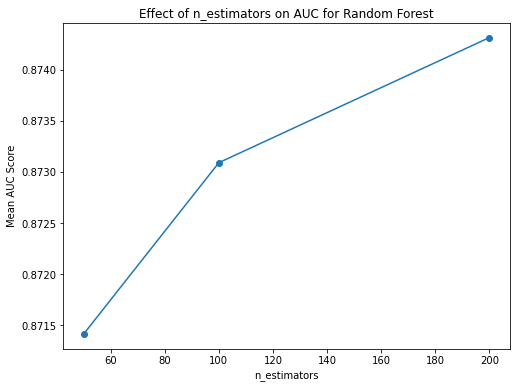

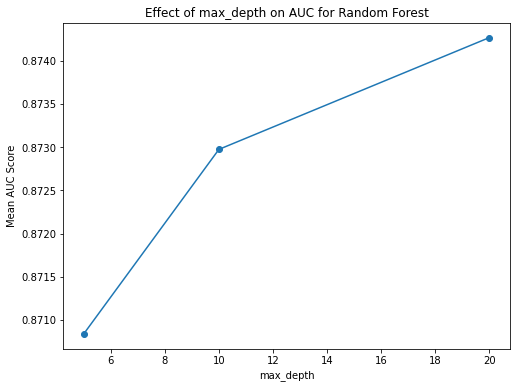

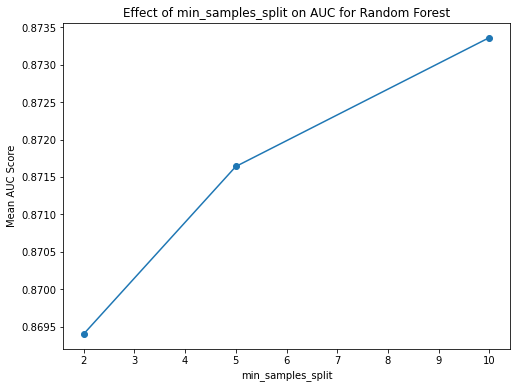

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10]
}

# Create the Random Forest model
model = RandomForestClassifier(random_state=0)

# Perform a grid search with cross-validation to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding AUC score
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best AUC Score: {best_auc:.4f}')

# Extract the results of the grid search
results = grid_search.cv_results_

# Plot the effect of n_estimators on AUC
plt.figure(figsize=(8, 6))
plt.plot(param_grid['n_estimators'], results['mean_test_score'][:3], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean AUC Score')
plt.title('Effect of n_estimators on AUC for Random Forest')
plt.show()

# Plot the effect of max_depth on AUC
plt.figure(figsize=(8, 6))
plt.plot(param_grid['max_depth'], results['mean_test_score'][3:6], marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean AUC Score')
plt.title('Effect of max_depth on AUC for Random Forest')
plt.show()

# Plot the effect of min_samples_split on AUC
plt.figure(figsize=(8, 6))
plt.plot(param_grid['min_samples_split'], results['mean_test_score'][6:9], marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Mean AUC Score')
plt.title('Effect of min_samples_split on AUC for Random Forest')
plt.show()

## Testing parameters from LogisticRegression model

In [12]:
# Define the parameter distribution for the randomized search
param_dist = {
    'C': np.logspace(-3, 3, 50),  # A range of C values from 0.001 to 1000
    'penalty': ['l1', 'l2']
}

# Create the Logistic Regression model
model = LogisticRegression(random_state=0)

# Perform a randomized search with cross-validation to find the best parameters
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', random_state=0)
random_search.fit(X_train, y_train)

# Get the best parameters and the corresponding AUC score
best_params = random_search.best_params_
best_auc = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best AUC Score: {best_auc:.4f}')

Best Parameters: {'penalty': 'l2', 'C': 1.151395399326447}

Best AUC Score: 0.8253


## Testing parameters from Gradient Boosting model

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}

Best AUC Score: 0.8900


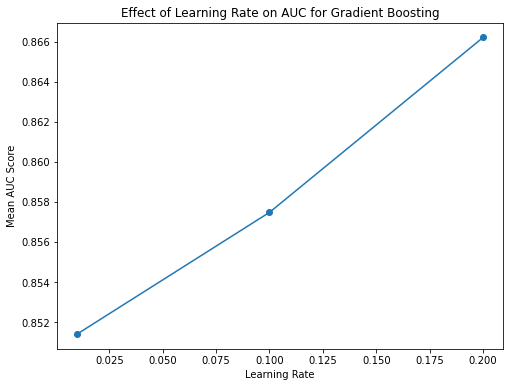

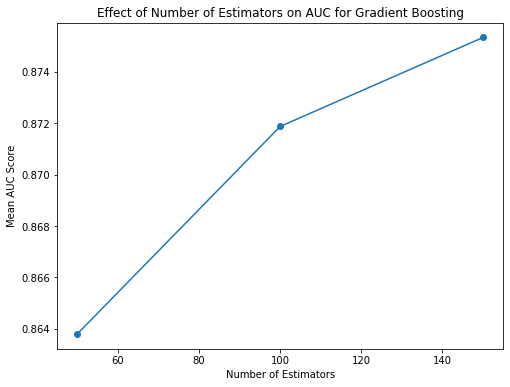

In [13]:
# Define the parameter grid for the Gradient Boosting model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

# Create the Gradient Boosting model
model = GradientBoostingClassifier(random_state=0)

# Perform a grid search with cross-validation to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding AUC score
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best AUC Score: {best_auc:.4f}')

# Extract the results of the grid search
results = grid_search.cv_results_

# Plot the effect of learning_rate on AUC
plt.figure(figsize=(8, 6))
plt.plot(param_grid['learning_rate'], results['mean_test_score'][:3], marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean AUC Score')
plt.title('Effect of Learning Rate on AUC for Gradient Boosting')
plt.show()

# Plot the effect of n_estimators on AUC
plt.figure(figsize=(8, 6))
plt.plot(param_grid['n_estimators'], results['mean_test_score'][3:6], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean AUC Score')
plt.title('Effect of Number of Estimators on AUC for Gradient Boosting')
plt.show()

## Cross-validating the optimized models:

In [14]:
# Define the optimized models to test
models = [
    ('Random Forest', RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=2, min_samples_split=5,n_estimators=200)),
    ('Logistic Regression', LogisticRegression(random_state=0, penalty='l2', C=1.15)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=0, learning_rate=0.1, max_depth=7, n_estimators=50)),
    ('Support Vector Machine', SVC(random_state=0, kernel='poly', C=10, degree=4)),
]

# Perform cross-validation for each model and calculate the mean AUC score
for model_name, model in models:
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print(f'{model_name}: Mean AUC Score = {mean_auc:.4f}')

Random Forest: Mean AUC Score = 0.8921

Logistic Regression: Mean AUC Score = 0.8253

Gradient Boosting: Mean AUC Score = 0.8900

Support Vector Machine: Mean AUC Score = 0.7917


## Final Function:

In [18]:
def engagement_model():
    rec = None

    # YOUR CODE HERE
    # Load the training and test datasets
    train_data = pd.read_csv('assets/train.csv', index_col='id')
    test_data = pd.read_csv('assets/test.csv', index_col='id')

    # Separate the features and target variable in the training data
    X_train = train_data.drop(columns=['engagement'])
    y_train = train_data['engagement']

    # Train a Random Forest classifier
    model = RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=2, min_samples_split=5,n_estimators=200)
    model.fit(X_train, y_train)

    # Predict the probabilities of engagement for the test data
    engagement_probabilities = model.predict_proba(test_data)[:, 1]

    # Create a Pandas Series with the probabilities and the video index as the id field
    rec = pd.Series(engagement_probabilities, name='engagement', dtype=np.float32)
    
    return rec

result = engagement_model()
print(result)

0       0.007045

1       0.069175

2       0.129674

3       0.855363

4       0.016726

          ...   

2304    0.016002

2305    0.001137

2306    0.009789

2307    0.856536

2308    0.011032

Name: engagement, Length: 2309, dtype: float32


In [19]:
stu_ans = engagement_model()
assert isinstance(stu_ans, pd.Series), "Your function should return a pd.Series. "
assert len(stu_ans) == 2309, "Your series is of incorrect length: expected 2309 "
assert np.issubdtype(stu_ans.index.dtype, np.integer), "Your answer pd.Series should have an index of integer type representing video id."

## Ploting ROC Curve:

0.8742959834000297


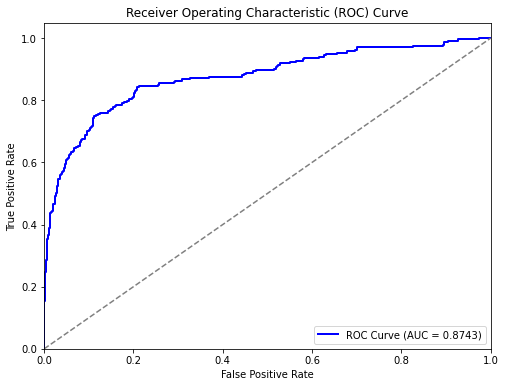

In [20]:
# Separate the features and target variable in the training data
X = train_data.drop(columns=['engagement'])
y = train_data['engagement']

# Split the data into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
model.fit(X_train, y_train)

# Predict the probabilities of engagement for the validation data
engagement_probabilities = model.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, engagement_probabilities)

# Calculate the AUC score
auc_score = roc_auc_score(y_val, engagement_probabilities)
print(auc_score)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [22]:
# Separate the features and target variable in the training data
X_train = train_data.drop(columns=['engagement'])
y_train = train_data['engagement']

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
model.fit(X_train, y_train)

# Get the predictions for the test_data
test_data = pd.read_csv('assets/test.csv', index_col='id')
predictions = model.predict(test_data)

# Add predictions to the test_data DataFrame
test_data['engagement_prediction'] = predictions

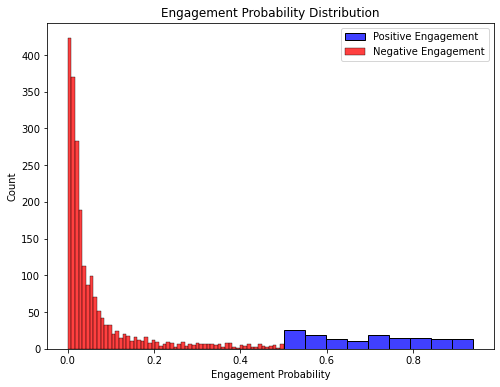

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement_prediction,engagement_probability
id,,,,,,,,,,
9240,6,8.548351,14140,89.827395,0.640810,0.017945,2.262723,0.000000,False,0.007045
9241,8,7.730110,14600,82.446667,0.606738,0.027708,2.690351,0.000000,False,0.069175
9242,3,8.200887,16980,88.821542,0.621089,0.009857,3.116071,0.000000,False,0.129674
9243,5,6.377299,16260,86.874660,0.600000,0.004348,2.837500,0.017994,True,0.855363
9244,18,7.756530,14030,88.872277,0.616105,0.033240,1.354839,0.000000,False,0.016726
...,...,...,...,...,...,...,...,...,...,...
11544,11,7.781813,13920,80.620236,0.611722,0.031276,2.193125,0.194918,False,0.016002
11545,3,7.800766,13990,94.080225,0.654741,0.013967,1.580000,0.338601,False,0.001137
11546,2,8.235828,14280,95.173070,0.618686,0.018486,5.548518,0.369348,False,0.009789


In [24]:
# Predict the probabilities of engagement for the test data
engagement_probabilities = model.predict_proba(test_data.drop(columns=['engagement_prediction']))[:, 1]

# Create a Pandas Series with the probabilities and the video index as the id field
rec = pd.Series(engagement_probabilities, name='engagement', dtype=np.float32)

# Add probabilities to the test_data DataFrame
test_data['engagement_probability'] = engagement_probabilities

# Plot the probabilities for positive and negative engagement predictions
plt.figure(figsize=(8, 6))
sns.histplot(test_data[test_data['engagement_prediction'] == True]['engagement_probability'], color='blue', label='Positive Engagement')
sns.histplot(test_data[test_data['engagement_prediction'] == False]['engagement_probability'], color='red', label='Negative Engagement')
plt.xlabel('Engagement Probability')
plt.ylabel('Count')
plt.title('Engagement Probability Distribution')
plt.legend()
plt.show()

# Show the updated test_data DataFrame
test_data

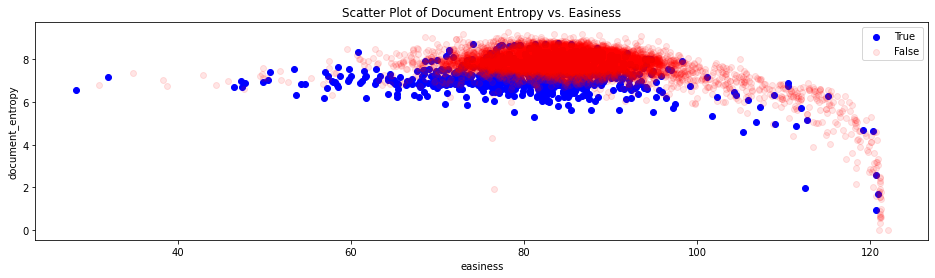

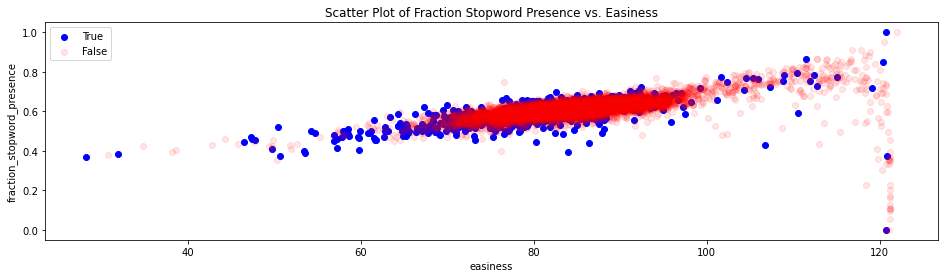

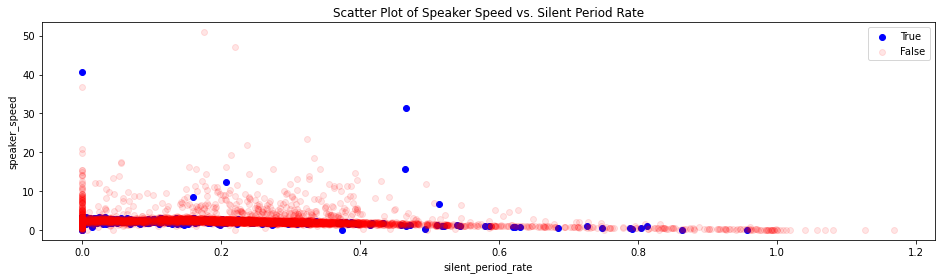

In [25]:
# Split the data into training and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
model.fit(X_train, y_train)

# Define the combinations of features to create scatter plots
feature_combinations = [('easiness', 'document_entropy', 'Scatter Plot of Document Entropy vs. Easiness'),
                        ('easiness', 'fraction_stopword_presence', 'Scatter Plot of Fraction Stopword Presence vs. Easiness'),
                        ('silent_period_rate', 'speaker_speed', 'Scatter Plot of Speaker Speed vs. Silent Period Rate')]

# Create scatter plots for each combination of features
for x_feature, y_feature, title in feature_combinations:
    plt.figure(figsize=(16, 4))
    plt.scatter(train_data.loc[train_data['engagement']==True, x_feature], train_data.loc[train_data['engagement']==True, y_feature], color='blue', label='True', alpha=1)
    plt.scatter(train_data.loc[train_data['engagement']==False, x_feature], train_data.loc[train_data['engagement']==False, y_feature], color='red', label='False', alpha=0.1)
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(title)
    plt.legend()
    plt.show()

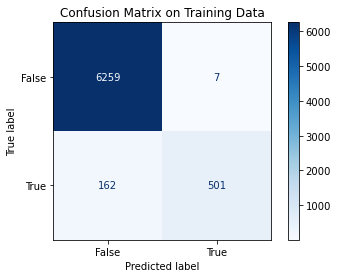

In [26]:
# Get the predictions on the training data
train_predictions = model.predict(X_train)

# Create the confusion matrix
cm = confusion_matrix(y_train, train_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix on Training Data')
plt.show()